In [1]:
from sklearn.datasets import make_circles, make_moons, make_swiss_roll, make_s_curve
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA

## Load Nonlinear Dataset

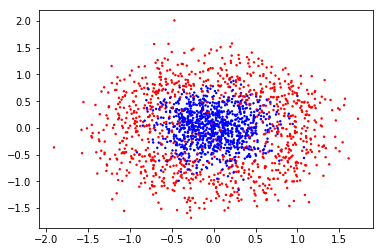

In [2]:
X, y = make_circles(n_samples=2000, factor=0.2, noise=0.3)
colors = ['red','blue']
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(colors), s=2)
y[y == 0] = -1

## Train/Test Split

In [3]:
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Define the Kernel Function

In [4]:
def gaussian_kernel(x1, x2, sigma=0.1):
    return np.exp(-LA.norm(x1-x2, axis=-1)**2 / (2*sigma**2))

## Compute the Gram Matrix

In [5]:
m,n = X_train.shape
y_train = y_train.reshape(-1,1) * 1.
K = np.zeros((m, m))

for i, x_i in enumerate(X_train):
    for j, x_j in enumerate(X_train):
        K[i, j] = gaussian_kernel(x_i, x_j)
K = np.outer(y_train, y_train) * K
K.shape

(1600, 1600)

## Use QP Solver to Solve the Dual

In [6]:
C = 10
P = matrix(K)
q = matrix(-np.ones(m))
G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = matrix(y_train, (1, m))
b = matrix(0.)

#Run solver
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

alphas = alphas.reshape(alphas.shape[0])

sup_vec_idx = np.argwhere(alphas > 1e-4)
sup_vec_idx = sup_vec_idx.reshape(sup_vec_idx.shape[0])
X_sup_vec = X_train[sup_vec_idx]
y_sup_vec = y_train[sup_vec_idx]
alphas_sup_vec = alphas[sup_vec_idx]

     pcost       dcost       gap    pres   dres
 0:  1.7298e+02 -5.2592e+04  7e+04  2e-01  1e-14
 1: -1.2669e+03 -9.9714e+03  9e+03  1e-02  9e-15
 2: -2.4067e+03 -5.4404e+03  3e+03  3e-03  8e-15
 3: -2.8461e+03 -4.1031e+03  1e+03  9e-04  8e-15
 4: -3.0286e+03 -3.4622e+03  4e+02  2e-04  8e-15
 5: -3.0943e+03 -3.2510e+03  2e+02  5e-05  8e-15
 6: -3.1203e+03 -3.1676e+03  5e+01  1e-05  8e-15
 7: -3.1273e+03 -3.1492e+03  2e+01  2e-06  8e-15
 8: -3.1312e+03 -3.1382e+03  7e+00  5e-07  8e-15
 9: -3.1326e+03 -3.1350e+03  2e+00  1e-07  8e-15
10: -3.1331e+03 -3.1340e+03  9e-01  3e-08  8e-15
11: -3.1333e+03 -3.1336e+03  3e-01  8e-09  8e-15
12: -3.1333e+03 -3.1334e+03  9e-02  1e-09  8e-15
13: -3.1334e+03 -3.1334e+03  2e-02  1e-10  9e-15
14: -3.1334e+03 -3.1334e+03  1e-03  6e-13  8e-15
Optimal solution found.


## Compute the Bias Term

In [7]:
y_sup_vec = y_sup_vec.reshape(y_sup_vec.shape[0])
sup_vec_num = sup_vec_idx.shape[0]
pred_mtx = np.zeros(sup_vec_num)
b = 0
for i in range(sup_vec_num):
    for j in range(sup_vec_num):
        pred_mtx[j] = gaussian_kernel(X_sup_vec[j], X_sup_vec[0])
    b += y_sup_vec[i] - np.sum(alphas_sup_vec * y_sup_vec * pred_mtx)
b /= sup_vec_num
b

-0.6694668435230676

## Make Predictions on Test Set

In [8]:
preds = []
for Xt in X_test:
    for i in range(sup_vec_num):
        pred_mtx[i] = gaussian_kernel(X_sup_vec[i], Xt)
    pred = np.sign(np.sum(alphas_sup_vec * y_sup_vec * pred_mtx))
    preds.append(int(pred))
preds = np.array(preds)

## Accuracy

In [9]:
np.sum((preds == y_test).astype("int")) / y_test.shape[0]

0.885